# ehrMGAN: Electronic Health Records Multiple Generative Adversarial Networks
This notebook implements the complete ehrMGAN model for generating synthetic electronic health records data. The model combines VAEs and GANs to generate both continuous (vital signs) and discrete (medications/interventions) time series data.

## 1. Environment Setup
First, let's set up our environment with the necessary imports and check the configuration.

In [10]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create directories if they don't exist
os.makedirs("data/checkpoint/", exist_ok=True)
os.makedirs("data/fake/", exist_ok=True)
os.makedirs("logs/", exist_ok=True)

# Environment information
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 1.14.0
NumPy version: 1.19.5
Pandas version: 1.1.5


In [2]:
import platform
import psutil
import GPUtil

# System info
print(f"System: {platform.system()} {platform.version()}")
print(f"Python version: {platform.python_version()}")
print(f"Processor: {platform.processor()}")

# Memory info
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024**3):.2f} GB")
print(f"Available memory: {memory.available / (1024**3):.2f} GB")

# GPU info
try:
    gpus = GPUtil.getGPUs()
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"GPU {i}: {gpu.name}, Memory: {gpu.memoryTotal} MB")
            print(f"   Memory used: {gpu.memoryUsed} MB, Load: {gpu.load*100:.1f}%")
    else:
        print("No GPU detected")
except:
    print("Could not detect GPU information")

# Check if TensorFlow sees GPUs
print("\nTensorFlow GPU availability:")
print(f"GPU available: {tf.test.is_gpu_available()}")

System: Windows 10.0.19041
Python version: 3.6.15
Processor: AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
Total memory: 31.93 GB
Available memory: 19.29 GB
GPU 0: NVIDIA GeForce RTX 3060, Memory: 12288.0 MB
   Memory used: 1167.0 MB, Load: 5.0%

TensorFlow GPU availability:
GPU available: False


### 2. Import Model Components
Now let's import the necessary model components from our files.

In [3]:
# Import the model components
import sys
sys.path.append('.')

# Let's first import the necessary modules
from networks import C_VAE_NET, D_VAE_NET, C_GAN_NET, D_GAN_NET
from m3gan import m3gan
from utils import renormlizer
from visualise import visualise_gan, visualise_vae

### 3. Data Loading and Preprocessing
Let's load and preprocess the data.

### Dealing with different data source

In [45]:
MIMIC_IV_VENT_LARGER_THAN_24_HR_FLAG = True
if MIMIC_IV_VENT_LARGER_THAN_24_HR_FLAG:
    prefix_path = "data/real/mimic_iv_vent_larger_than_24_hr"
    baseline_charttime_ground_truth_df = pd.read_csv(f"{prefix_path}/baseline_charttime_ground_truth.csv")
    baseline_charttime_ground_truth_df.columns

In [46]:
def normalize_and_format_mimic_iv_data(baseline_charttime_ground_truth_df):
    """
    Normalize continuous features to 0-1 range, save normalization parameters,
    and format data to match the required structure.
    """
    # Define the continuous features to use
    continuous_feature_names = [
        'heart_rate',            # Heart Rate
        'resp_rate',             # Respiratory Rate
        'spo2',                  # O2 saturation pulseoxymetry
        'fio2',                  # Inspired O2 Fraction
        'respiratory_rate_set'   # Respiratory Rate (Set)
    ]
    
    # Create a directory for saving normalization parameters if it doesn't exist
    os.makedirs(f'{prefix_path}', exist_ok=True)
    
    # Step 1: Calculate min and max values for normalization
    min_values = []
    max_values = []
    
    for feature in continuous_feature_names:
        # Skip features not present in the dataframe
        if feature not in baseline_charttime_ground_truth_df.columns:
            print(f"Warning: {feature} not found in dataframe. Using default min=0, max=1")
            min_values.append(0)
            max_values.append(1)
            continue
        
        # Get min and max, handling potential NaN values
        min_val = baseline_charttime_ground_truth_df[feature].min()
        max_val = baseline_charttime_ground_truth_df[feature].max()
        
        # Safety check for constant features
        if min_val == max_val:
            print(f"Warning: {feature} has constant value {min_val}. Adding small epsilon.")
            max_val = min_val + 1e-6
        
        min_values.append(min_val)
        max_values.append(max_val)
        
        print(f"{feature}: min={min_val}, max={max_val}")
    
    # Save normalization parameters
    norm_params = {
        'feature_names': continuous_feature_names,
        'min_val': np.array(min_values),
        'max_val': np.array(max_values)
    }
    
    np.savez(f'{prefix_path}norm_stats_5_var_mimiciv.npz', **norm_params)
    print(f"Normalization parameters saved to {prefix_path}/norm_stats_5_var_mimiciv.npz")
    
    # Get unique stay_ids
    unique_stay_ids = baseline_charttime_ground_truth_df['stay_id'].unique()
    num_patients = len(unique_stay_ids)
    print(f"Number of unique patients: {num_patients}")
    
    # Initialize arrays with correct shapes
    continuous_x = np.zeros((num_patients, 24, len(continuous_feature_names)))
    discrete_x = np.ones((num_patients, 24, 1))  # All discrete values set to 1
    statics_label = np.zeros((num_patients, 1))
    
    # Process each patient
    for i, stay_id in enumerate(unique_stay_ids):
        # Get data for this patient
        patient_data = baseline_charttime_ground_truth_df[baseline_charttime_ground_truth_df['stay_id'] == stay_id]
        
        # Get the last 24 hours of data
        # Assuming before_weaning_hr represents hours before weaning (smaller = closer to weaning)
        # patient_data_sorted = patient_data.sort_values(by='before_weaning_hr')
        patient_data_sorted = patient_data[patient_data['before_weaning_hr'] < 24]
        last_24hr_indices = patient_data_sorted.index  # Take first 24 rows (closest to weaning)

        # For each feature, extract and normalize values
        for j, feature in enumerate(continuous_feature_names):
            if feature in patient_data.columns:
                # Get raw values for this feature
                if not last_24hr_indices.empty:
                    raw_values = patient_data.loc[last_24hr_indices, feature].values
                    
                    # Handle case where we have fewer than 24 hours of data
                    if len(raw_values) < 24:
                        # Pad with the last available value
                        last_value = raw_values[-1] if len(raw_values) > 0 else 0
                        raw_values = np.pad(raw_values, (0, 24 - len(raw_values)), 
                                           mode='constant', constant_values=last_value)
                    
                    # Normalize to 0-1 range
                    normalized_values = (raw_values - min_values[j]) / (max_values[j] - min_values[j])
                    
                    # Clip to ensure values stay within 0-1 range (handles outliers)
                    normalized_values = np.clip(normalized_values, 0, 1)
                    
                    # Store in continuous_x
                    continuous_x[i, :, j] = normalized_values[:24]  # Ensure we only take 24 hours
                else:
                    # If no data available, use median normalized value (0.5)
                    continuous_x[i, :, j] = 0.5
        
        # Get the static label for this patient (outcome label)
        if 'stay_id' in patient_data.columns:
            statics_label[i, 0] = patient_data['stay_id'].iloc[0]
    
    # Print data statistics
    print("\nContinuous data statistics:")
    print(f"Shape: {continuous_x.shape}")
    print(f"Mean: {np.mean(continuous_x, axis=(0,1))}")
    print(f"Std: {np.std(continuous_x, axis=(0,1))}")
    print(f"Min: {np.min(continuous_x, axis=(0,1))}")
    print(f"Max: {np.max(continuous_x, axis=(0,1))}")
    
    print("\nDiscrete data statistics:")
    print(f"Shape: {discrete_x.shape}")
    print(f"Mean: {np.mean(discrete_x)}")
    print(f"Std: {np.std(discrete_x)}")
    
    print("\nStatics label statistics:")
    print(f"Shape: {statics_label.shape}")
    print(f"Label distribution: {np.bincount(statics_label.astype(int).flatten())}")
    
    # Save the formatted data
    np.savetxt(f'{prefix_path}/vital_sign_24hrs_5_var_mimiciv.txt', continuous_x.reshape(-1, continuous_x.shape[1] * continuous_x.shape[2]))
    np.savetxt(f'{prefix_path}/med_interv_24hrs_5_var_mimiciv.txt', discrete_x.reshape(-1, discrete_x.shape[1] * discrete_x.shape[2]))
    
    # Save static labels
    pd.DataFrame(statics_label).to_csv(f'{prefix_path}/static_data_5_var_mimiciv.csv', index=False)
    
    print("\nAll data saved to disk.")
    
    return continuous_x, discrete_x, statics_label, norm_params

In [47]:
def renormalize_data(normalized_data, norm_params=None, norm_file=None):
    """
    Convert normalized data back to original scale.
    
    Parameters:
    -----------
    normalized_data : numpy.ndarray
        Normalized data in range 0-1
    norm_params : dict, optional
        Dictionary containing 'min_val' and 'max_val'
    norm_file : str, optional
        Path to the .npz file containing normalization parameters
        
    Returns:
    --------
    numpy.ndarray
        Data in original scale
    """
    if norm_params is None:
        if norm_file is None:
            norm_file = f'{prefix_path}/norm_stats_5_var_mimiciv.npz'
        
        # Load normalization parameters
        norm_params = np.load(norm_file)
    
    min_vals = norm_params['min_val']
    max_vals = norm_params['max_val']
    
    # Reshape for broadcasting if needed
    if len(normalized_data.shape) == 3:  # (patients, timesteps, features)
        min_vals = min_vals.reshape(1, 1, -1)
        max_vals = max_vals.reshape(1, 1, -1)
    
    # Apply denormalization formula: original = normalized * (max - min) + min
    original_data = normalized_data * (max_vals - min_vals) + min_vals
    
    return original_data

# Example usage:
# original_continuous_x = renormalize_data(continuous_x)
# original_continuous_x

In [48]:
# When using the MIMIC_IV_VENT_LARGER_THAN_24_HR_FLAG
if MIMIC_IV_VENT_LARGER_THAN_24_HR_FLAG:
    continuous_x, discrete_x, statics_label, norm_params = normalize_and_format_mimic_iv_data(baseline_charttime_ground_truth_df)
else:
    # Data parameters
    patinet_num = 16062
    filename_postfix = '5_var'

    # Load continuous data (vital signs)
    continuous_x = np.loadtxt(f'data/real/mimic/vital_sign_24hrs_{filename_postfix}_mimiciv.txt')
    continuous_x = continuous_x.reshape(patinet_num, 24, 5)
    print(f"Continuous data shape: {continuous_x.shape}")

    # Load discrete data (medications/interventions)
    discrete_x = np.loadtxt(f'data/real/mimic/med_interv_24hrs_{filename_postfix}_mimiciv.txt')
    discrete_x = discrete_x.reshape(patinet_num, 24, 1)
    print(f"Discrete data shape: {discrete_x.shape}")

    # Load static data (patient demographics)
    statics_label = pd.read_csv(f'data/real/mimic/static_data_{filename_postfix}_mimiciv.csv')
    statics_label = np.asarray(statics_label)[:, 0].reshape([-1, 1])
    print(f"Static labels shape: {statics_label.shape}")

# Data statistics
print("\nContinuous data statistics:")
print(f"Mean: {np.mean(continuous_x, axis=(0,1))}")
print(f"Std: {np.std(continuous_x, axis=(0,1))}")
print(f"Min: {np.min(continuous_x, axis=(0,1))}")
print(f"Max: {np.max(continuous_x, axis=(0,1))}")

print("\nDiscrete data statistics:")
print(f"Mean: {np.mean(discrete_x)}")
print(f"Std: {np.std(discrete_x)}")
print(f"Min: {np.min(discrete_x)}")
print(f"Max: {np.max(discrete_x)}")

# Optional: Use a subset for faster experimentation
use_subset = False
subset_size = 5000
if use_subset:
    indices = np.random.choice(continuous_x.shape[0], subset_size, replace=False)
    continuous_x = continuous_x[indices]
    discrete_x = discrete_x[indices]
    statics_label = statics_label[indices]
    print(f"\nUsing subset of data: {subset_size} samples")

heart_rate: min=37.0, max=180.0
resp_rate: min=4.5, max=36.5
spo2: min=80.0, max=100.0
fio2: min=21.0, max=100.0
respiratory_rate_set: min=5.0, max=40.0
Normalization parameters saved to data/real/mimic_iv_vent_larger_than_24_hr/norm_stats_5_var_mimiciv.npz
Number of unique patients: 10158

Continuous data statistics:
Shape: (10158, 24, 5)
Mean: [0.33903176 0.47900746 0.88871148 0.29372876 0.3544334 ]
Std: [0.12719539 0.17155328 0.12501978 0.15315365 0.13977227]
Min: [0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1.]

Discrete data statistics:
Shape: (10158, 24, 1)
Mean: 1.0
Std: 0.0

Statics label statistics:
Shape: (10158, 1)
Label distribution: [0 0 0 ... 0 0 1]

All data saved to disk.

Continuous data statistics:
Mean: [0.33903176 0.47900746 0.88871148 0.29372876 0.3544334 ]
Std: [0.12719539 0.17155328 0.12501978 0.15315365 0.13977227]
Min: [0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1.]

Discrete data statistics:
Mean: 1.0
Std: 0.0
Min: 1.0
Max: 1.0


### 4. Model Configuration and Hyperparameter Tuning
Let's define our hyperparameters based on the data dimensions.

In [5]:
# Configure hyperparameters based on data dimensions
time_steps = continuous_x.shape[1]  # 24 hours
c_dim = continuous_x.shape[2]       # 5 continuous features
d_dim = discrete_x.shape[2]         # 1 discrete feature
num_samples = continuous_x.shape[0] # Number of patients

# Latent space dimensions
# For complex data with higher dimensions, we need a larger latent space
shared_latent_dim = 15 
c_z_size = shared_latent_dim
c_noise_dim = max(2, int(c_dim/2))  # At least 2 dimensions
d_z_size = shared_latent_dim
d_noise_dim = max(1, int(d_dim/2))  # At least 1 dimension

# Network sizes - scale based on data complexity
batch_size = 1024  # Can be adjusted based on memory constraints
enc_dec_size = 128  # For 5 features, 128 is reasonable
enc_dec_layers = 2  # For 24 time steps, 2-3 layers is reasonable
gen_units = 256     # For generation quality
gen_layers = 2
disc_units = 128
disc_layers = 2
dropout_keep = 0.8  # 0.8 is typically good for medical data

# Learning rates - typically smaller for stable training
v_lr_pre = 0.005   # VAE pretraining
v_lr = 0.0005       # VAE fine-tuning
g_lr = 0.0005       # Generator
d_lr = 0.0005       # Discriminator

# Training parameters
use_subset = False
if use_subset:
    num_pre_epochs = 36
    num_epochs = 60
else:
    num_pre_epochs = 300  # For 16K patients, 300 pre-epochs should be sufficient
    num_epochs = 500      # For GAN stability, 500 epochs should work well
d_rounds = 1          # Standard practice
g_rounds = 3          # Multiple generator updates per discriminator update
v_rounds = 1          # VAE updates

# Loss weights
alpha_re = 1.0    # Reconstruction weight (primary objective)
alpha_kl = 0.5    # KL divergence weight
alpha_mt = 0.2    # Matching weight (increased for better coordination)
alpha_ct = 0.2    # Contrastive weight (increased for feature learning)
alpha_sm = 1.0    # Semantic weight

# GAN loss weights
c_beta_adv = 1.0   # Adversarial weight for continuous
c_beta_fm = 10.0   # Feature matching for continuous (reduced to prevent mode collapse)
d_beta_adv = 1.0   # Adversarial weight for discrete
d_beta_fm = 10.0   # Feature matching for discrete (reduced for stability)

# Regularization
l2_scale = 0.001   # L2 regularization

# Conditional GAN parameters
conditional = False  # Whether to use conditional GAN
num_labels = 1 if conditional else 0  # Number of conditional labels

# Display configuration
print("Model Configuration:")
print(f"Latent dimensions - Continuous: {c_z_size}, Discrete: {d_z_size}")
print(f"Noise dimensions - Continuous: {c_noise_dim}, Discrete: {d_noise_dim}")
print(f"Batch size: {batch_size}")
print(f"Pre-training epochs: {num_pre_epochs}, Training epochs: {num_epochs}")
print(f"Network sizes - Encoder/Decoder: {enc_dec_size}, Generator: {gen_units}, Discriminator: {disc_units}")
print(f"Network layers - Encoder/Decoder: {enc_dec_layers}, Generator: {gen_layers}, Discriminator: {disc_layers}")
print(f"Learning rates - VAE pre: {v_lr_pre}, VAE: {v_lr}, Generator: {g_lr}, Discriminator: {d_lr}")

Model Configuration:
Latent dimensions - Continuous: 15, Discrete: 15
Noise dimensions - Continuous: 2, Discrete: 1
Batch size: 1024
Pre-training epochs: 300, Training epochs: 500
Network sizes - Encoder/Decoder: 128, Generator: 256, Discriminator: 128
Network layers - Encoder/Decoder: 2, Generator: 2, Discriminator: 2
Learning rates - VAE pre: 0.005, VAE: 0.0005, Generator: 0.0005, Discriminator: 0.0005


### 5. Build Model Components
Now let's build the model components.

In [6]:
# For TF1.x compatibility
tf.reset_default_graph()

# Define the VAE and GAN networks
c_vae = C_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=c_dim,
    z_dim=c_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

c_gan = C_GAN_NET(
    batch_size=batch_size,
    noise_dim=c_noise_dim,
    dim=c_dim,
    gen_dim=c_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_vae = D_VAE_NET(
    batch_size=batch_size,
    time_steps=time_steps,
    dim=d_dim,
    z_dim=d_z_size,
    enc_size=enc_dec_size,
    dec_size=enc_dec_size,
    enc_layers=enc_dec_layers,
    dec_layers=enc_dec_layers,
    keep_prob=dropout_keep,
    l2scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

d_gan = D_GAN_NET(
    batch_size=batch_size,
    noise_dim=d_noise_dim,
    dim=d_dim,
    gen_dim=d_z_size,
    time_steps=time_steps,
    gen_num_units=gen_units,
    gen_num_layers=gen_layers,
    dis_num_units=disc_units,
    dis_num_layers=disc_layers,
    keep_prob=dropout_keep,
    l2_scale=l2_scale,
    conditional=conditional,
    num_labels=num_labels
)

### 6. Create and Train the Model
Now let's set up the complete model and train it.

In [ ]:
# Define checkpoint directory
checkpoint_dir = "data/checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

# REPLACE the model building section (cell #6) with this:
# Reset the TensorFlow graph to avoid variable conflicts
tf.reset_default_graph()
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True
sess = tf.Session(config=run_config)

# Create the complete M3GAN model
model = m3gan(
    sess=sess,
    batch_size=batch_size,
    time_steps=time_steps,
    num_pre_epochs=num_pre_epochs,
    num_epochs=num_epochs,
    checkpoint_dir=checkpoint_dir,
    epoch_ckpt_freq=50,  # Save checkpoint every 100 epochs
    epoch_loss_freq=1,   # Display loss every 10 epochs
    
    # Continuous parameters
    c_dim=c_dim,
    c_noise_dim=c_noise_dim,
    c_z_size=c_z_size,
    c_data_sample=continuous_x,
    c_vae=c_vae,
    c_gan=c_gan,
    
    # Discrete parameters
    d_dim=d_dim,
    d_noise_dim=d_noise_dim,
    d_z_size=d_z_size,
    d_data_sample=discrete_x,
    d_vae=d_vae,
    d_gan=d_gan,
    
    # Training parameters
    d_rounds=d_rounds,
    g_rounds=g_rounds,
    v_rounds=v_rounds,
    v_lr_pre=v_lr_pre,
    v_lr=v_lr,
    g_lr=g_lr,
    d_lr=d_lr,
    
    # Loss weights
    alpha_re=alpha_re,
    alpha_kl=alpha_kl,
    alpha_mt=alpha_mt,
    alpha_ct=alpha_ct,
    alpha_sm=alpha_sm,
    c_beta_adv=c_beta_adv,
    c_beta_fm=c_beta_fm,
    d_beta_adv=d_beta_adv,
    d_beta_fm=d_beta_fm,
    
    # Conditional parameters
    conditional=conditional,
    num_labels=num_labels,
    statics_label=statics_label
)

# Build the model
print("Building the model...")
model.build()

In [ ]:
# REPLACE the training section (cell #8) with:
# Initialize variables or restore from checkpoint
print("Initializing or restoring model...")
checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint:
    print(f"Restoring model from checkpoint: {checkpoint}")
    # Only create the saver after the model is built
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint)
else:
    print("No checkpoint found, initializing variables")
    sess.run(tf.global_variables_initializer())

# Train the model
print("Starting training...")
start_time = timeit.default_timer()

# Only run this cell for training - you can comment it out to skip training
train_model = True
if train_model:
    model.train()
    # Save the final model - create saver only if needed to avoid variable conflicts
    if 'saver' not in locals():
        saver = tf.train.Saver()
    save_path = os.path.join(checkpoint_dir, "final_model")
    saver.save(sess, save_path)
    print(f"Model saved to {save_path}")

end_time = timeit.default_timer()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

### 7.2 Addressing First Hour Low Variance Issue
Let's analyze and fix the issue with low standard deviation in the first hour.

Generating synthetic data...


Renormalizing generated data...
Analyzing variance across time steps...


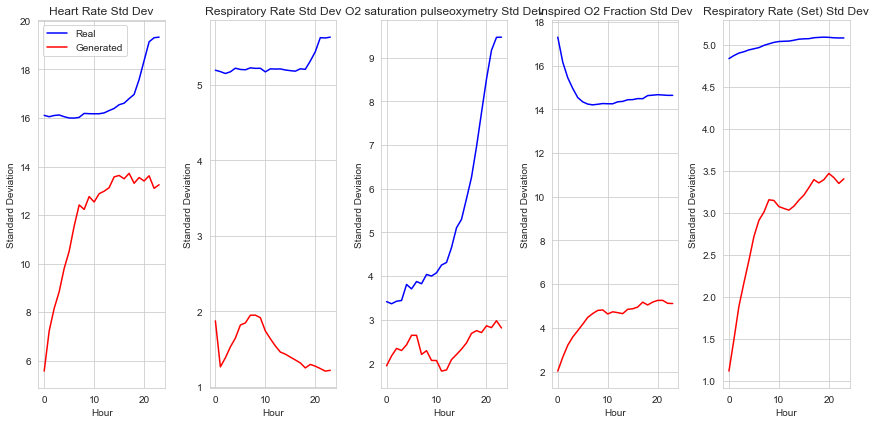


Applying variance correction to the first hour...

Applying enhanced variance correction to the first hour...


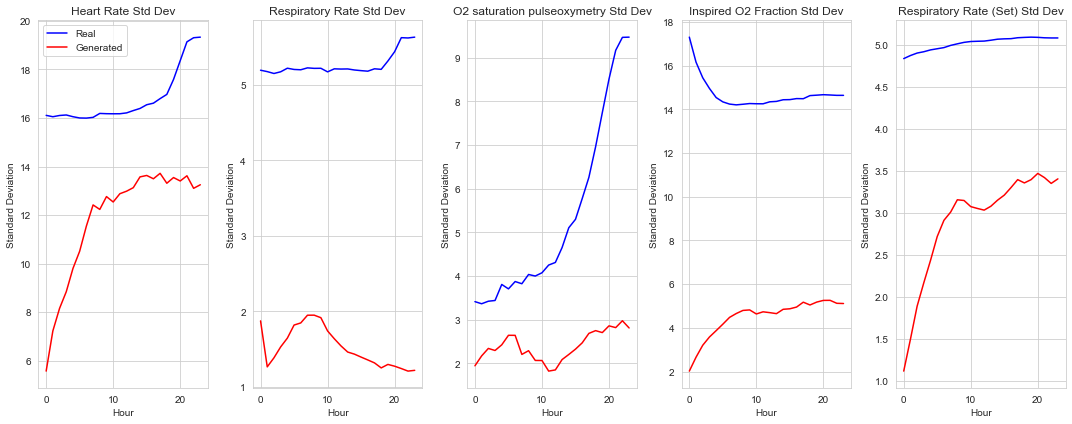

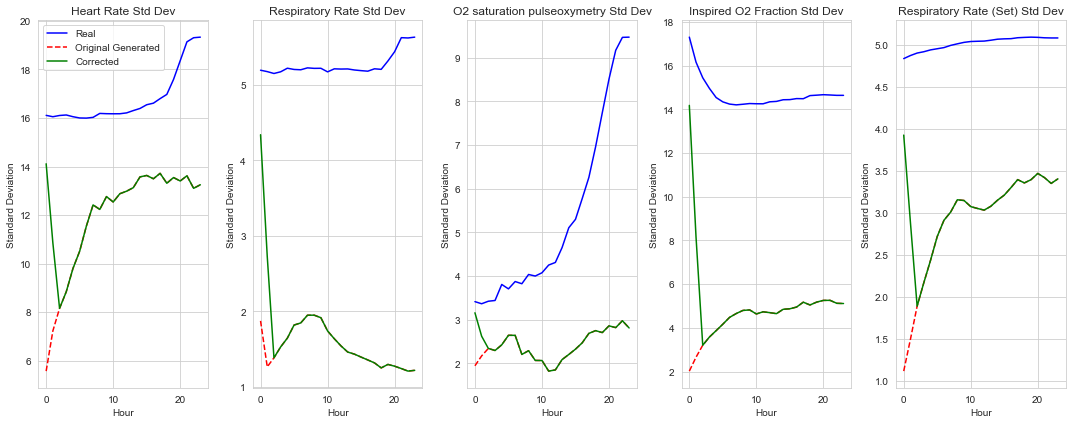

Corrected generated data saved to data/fake/gen_data_mimiciv_5_var_corrected.npz


In [ ]:
# Generate data first
print("Generating synthetic data...")
d_gen_data, c_gen_data = model.generate_data(num_sample=1024)

# Apply renormalization if your data was normalized
print("Renormalizing generated data...")
# c_gen_data_renorm = c_gen_data  # If no renormalization needed
# If renormalization needed:
# c_gen_data_renorm = renormlizer(c_gen_data, data_info) # TODO: Implement renormlizer
# renormalize
filename_postfix = '5_var'
min_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["min_val"]
max_val_con = np.load(os.path.join('data/real/', 'mimic', f"norm_stats_{filename_postfix}_mimiciv.npz"))["max_val"]
c_gen_data_renorm = renormlizer(c_gen_data, max_val_con, min_val_con)
continuous_x_renorm = renormlizer(continuous_x, max_val_con, min_val_con)


# Analyze the first hour variance issue
print("Analyzing variance across time steps...")
real_std_by_hour = np.std(continuous_x_renorm, axis=0)
gen_std_by_hour = np.std(c_gen_data_renorm, axis=0)

# Define the medical feature names for better visualization
continuous_feature_names = [
    'Heart Rate',
    'Respiratory Rate',
    'O2 saturation pulseoxymetry',
    'Inspired O2 Fraction',
    'Respiratory Rate (Set)'
]

# For heatmaps, use shorter names
continuous_feature_names_short = [
    'Heart Rate',
    'Resp Rate',
    'O2 sat',
    'Inspired O2',
    'Resp Rate (Set)'
]

# Plot the standard deviation over time
plt.figure(figsize=(12, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Fix the low variance issue with a post-processing step
print("\nApplying variance correction to the first hour...")

# Improved variance matching function with consistency preservation
def variance_matching(data, target_std, axis=0, smoothing_factor=0.7):
    """
    Match variance of data to target_std while preserving mean and temporal consistency
    
    Args:
        data: The data to adjust
        target_std: The target standard deviation
        axis: Axis along which to compute statistics
        smoothing_factor: How much to smooth between original and adjusted values (0-1)
                         Higher means more of the original preserved
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + 1e-10  # Avoid division by zero
    
    # Normalize the data
    normalized = (data - mean) / std
    
    # Scale to target std dev and shift back to original mean
    adjusted = normalized * target_std + mean
    
    # Apply smoothing to preserve some of the original structure
    result = smoothing_factor * data + (1 - smoothing_factor) * adjusted
    
    return result

# Apply the correction to the first hour with improvements
print("\nApplying enhanced variance correction to the first hour...")
c_gen_data_corrected = c_gen_data_renorm.copy()

for i in range(c_dim):
    # First hour data
    first_hour_data = c_gen_data_corrected[:, 0, i].reshape(-1, 1)
    
    # Target std dev with slight randomization for more natural results
    target_std = real_std_by_hour[0, i] * np.random.uniform(1.0, 1.15)
    
    # Apply variance matching with trajectory consistency preservation
    c_gen_data_corrected[:, 0, i] = variance_matching(
        first_hour_data, target_std, axis=0, smoothing_factor=0.3
    ).flatten()
    
    # For natural transitions, also slightly adjust the second hour
    if time_steps > 1:
        second_hour_data = c_gen_data_corrected[:, 1, i].reshape(-1, 1)
        target_std_2 = real_std_by_hour[1, i] * np.random.uniform(0.95, 1.05)
        c_gen_data_corrected[:, 1, i] = variance_matching(
            second_hour_data, target_std_2, axis=0, smoothing_factor=0.6
        ).flatten()

""" plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'Feature {i+1} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """

# Plot the standard deviation over time
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r-', label='Generated')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Verify the correction
corrected_std_by_hour = np.std(c_gen_data_corrected, axis=0)

plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i+1)
    plt.plot(range(time_steps), real_std_by_hour[:, i], 'b-', label='Real')
    plt.plot(range(time_steps), gen_std_by_hour[:, i], 'r--', label='Original Generated')
    plt.plot(range(time_steps), corrected_std_by_hour[:, i], 'g-', label='Corrected')
    plt.title(f'{feature_name} Std Dev')
    plt.xlabel('Hour')
    plt.ylabel('Standard Deviation')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Save the corrected data
save_path_corrected = f"data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz"
np.savez(save_path_corrected, 
         c_gen_data=c_gen_data_corrected, 
         d_gen_data=d_gen_data)
print(f"Corrected generated data saved to {save_path_corrected}")

### 7.3 Visualization and Analysis

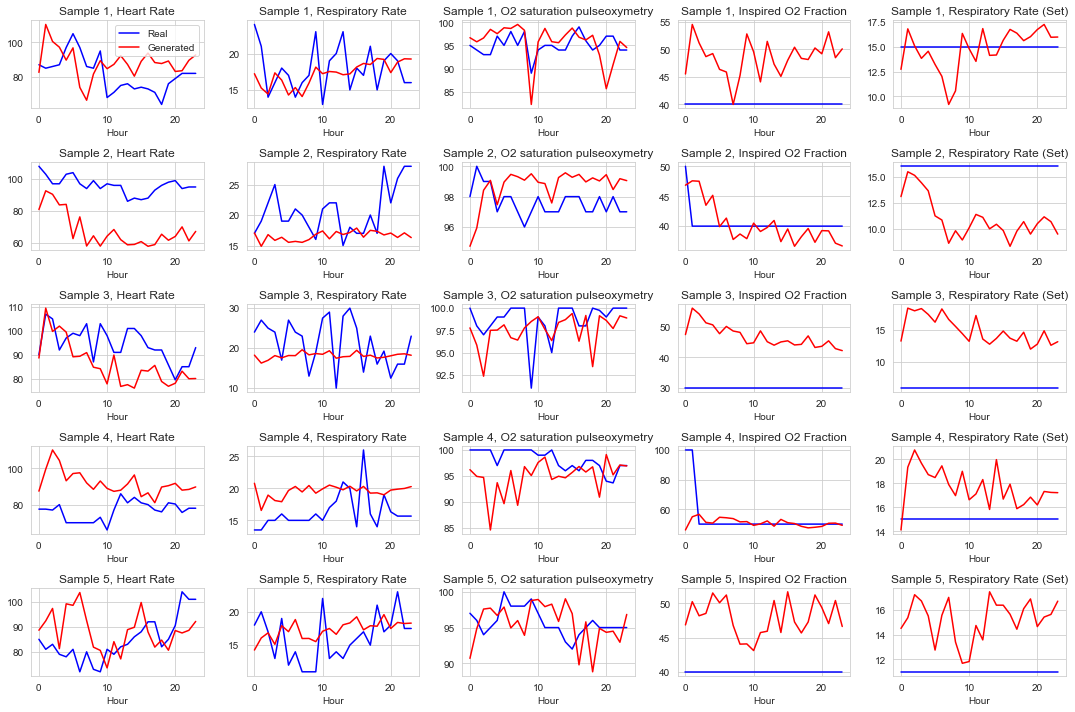

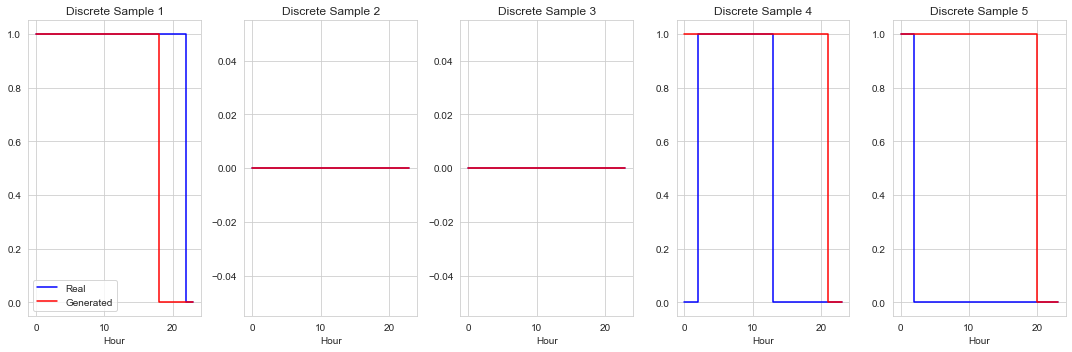

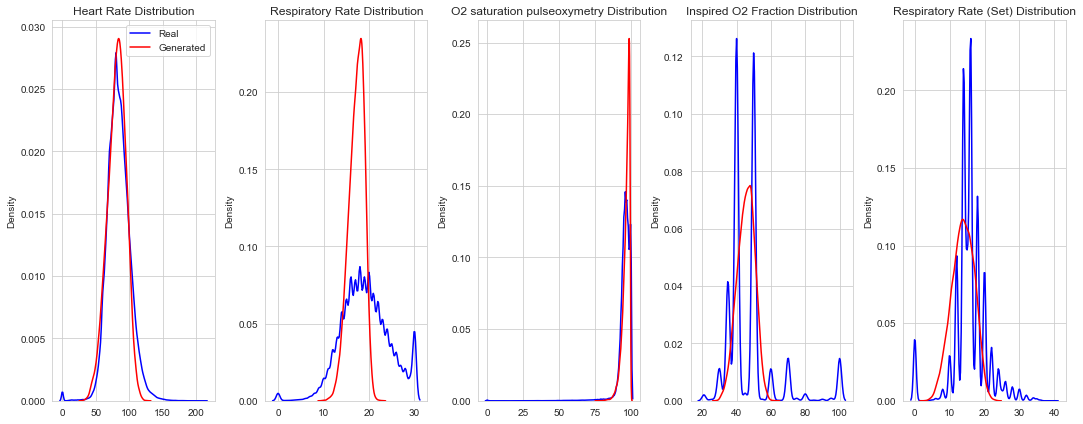

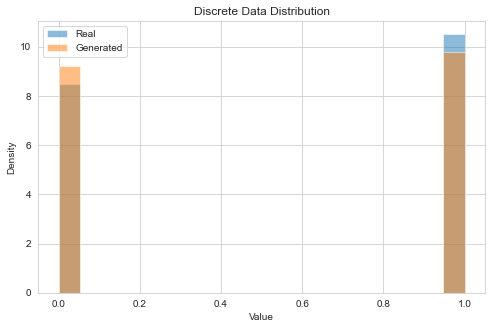

In [10]:
# Sample and visualize a few trajectories
num_samples_to_visualize = 5
sample_indices = np.random.choice(c_gen_data.shape[0], num_samples_to_visualize, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    # Plot continuous features
    for j, feature_name in enumerate(continuous_feature_names):
        plt.subplot(num_samples_to_visualize, c_dim, i*c_dim + j + 1)
        plt.plot(range(time_steps), continuous_x_renorm[idx, :, j], 'b-', label='Real')
        plt.plot(range(time_steps), c_gen_data_renorm[idx, :, j], 'r-', label='Generated')
        if i == 0 and j == 0:
            plt.legend()
        plt.title(f'Sample {i+1}, {feature_name}')
        plt.xlabel('Hour')
plt.tight_layout()
plt.show()

# For discrete data
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.step(range(time_steps), discrete_x[idx, :, 0], 'b-', where='post', label='Real')
    plt.step(range(time_steps), d_gen_data[idx, :, 0], 'r-', where='post', label='Generated')
    if i == 0:
        plt.legend()
    plt.title(f'Discrete Sample {i+1}')
    plt.xlabel('Hour')
plt.tight_layout()
plt.show()

""" # Compare distributions
plt.figure(figsize=(15, 6))
for i in range(c_dim):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'Feature {i+1} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show() """
# Compare distributions
plt.figure(figsize=(15, 6))
for i, feature_name in enumerate(continuous_feature_names):
    plt.subplot(1, c_dim, i + 1)
    sns.kdeplot(continuous_x_renorm[:, :, i].flatten(), label='Real', color='blue')
    sns.kdeplot(c_gen_data_renorm[:, :, i].flatten(), label='Generated', color='red')
    plt.title(f'{feature_name} Distribution')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Discrete data distribution
plt.figure(figsize=(8, 5))
bins = np.linspace(0, 1, 20)
plt.hist(discrete_x.flatten(), bins=bins, alpha=0.5, label='Real', density=True)
plt.hist(d_gen_data.flatten(), bins=bins, alpha=0.5, label='Generated', density=True)
plt.legend()
plt.title('Discrete Data Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

### 8. Advanced Analysis: Preserving Medical Correlations

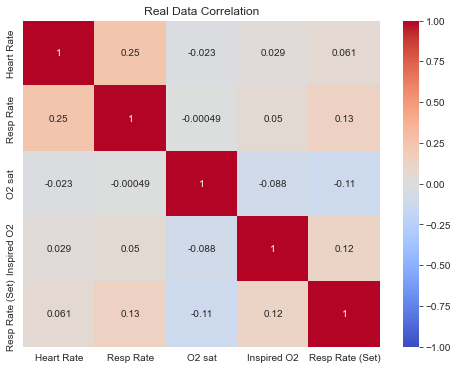

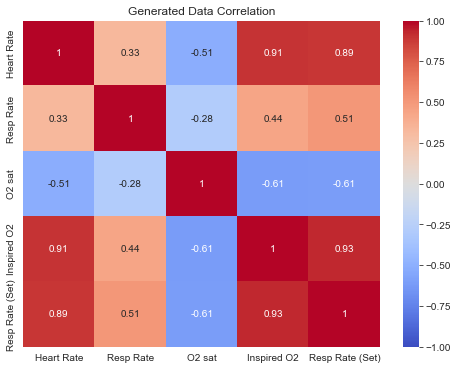

Mean absolute correlation difference: 0.4136


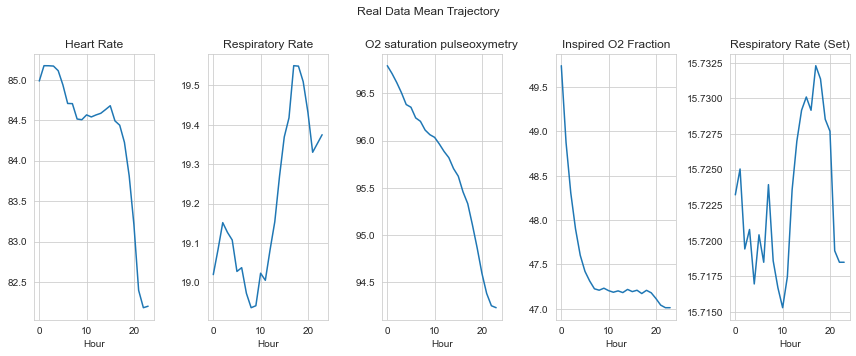

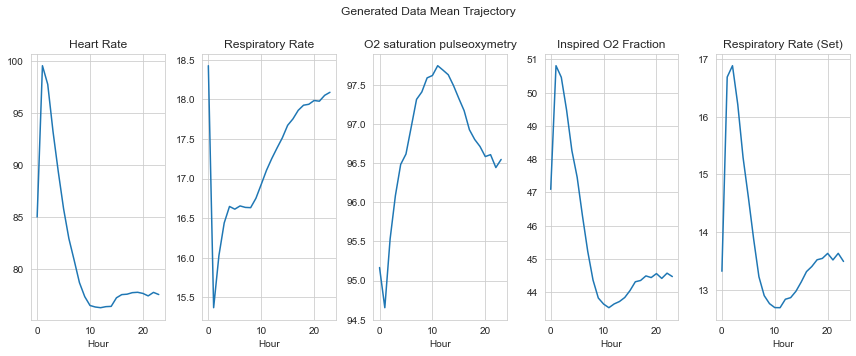

In [11]:
# Analyze correlations between features
def plot_correlation_heatmap(data, title):
    # Reshape to (patients*times, features)
    data_flat = data.reshape(-1, data.shape[2])
    
    # Calculate correlation matrix
    corr = np.corrcoef(data_flat.T)
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
               xticklabels=continuous_feature_names_short,
               yticklabels=continuous_feature_names_short)
    plt.title(title)
    plt.show()
    return corr

# Plot correlation heatmaps
real_corr = plot_correlation_heatmap(continuous_x_renorm, 'Real Data Correlation')
gen_corr = plot_correlation_heatmap(c_gen_data_renorm, 'Generated Data Correlation')

# Calculate correlation difference
corr_diff = np.abs(real_corr - gen_corr)
print(f"Mean absolute correlation difference: {np.mean(corr_diff):.4f}")

# Visualize temporal patterns
def plot_mean_trajectory(data, title):
    mean_trajectory = np.mean(data, axis=0)
    
    plt.figure(figsize=(12, 5))
    for i, feature_name in enumerate(continuous_feature_names):
        plt.subplot(1, data.shape[2], i+1)
        plt.plot(range(data.shape[1]), mean_trajectory[:, i])
        plt.title(f'{feature_name}')
        plt.xlabel('Hour')
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_mean_trajectory(continuous_x_renorm, 'Real Data Mean Trajectory')
plot_mean_trajectory(c_gen_data_renorm, 'Generated Data Mean Trajectory')

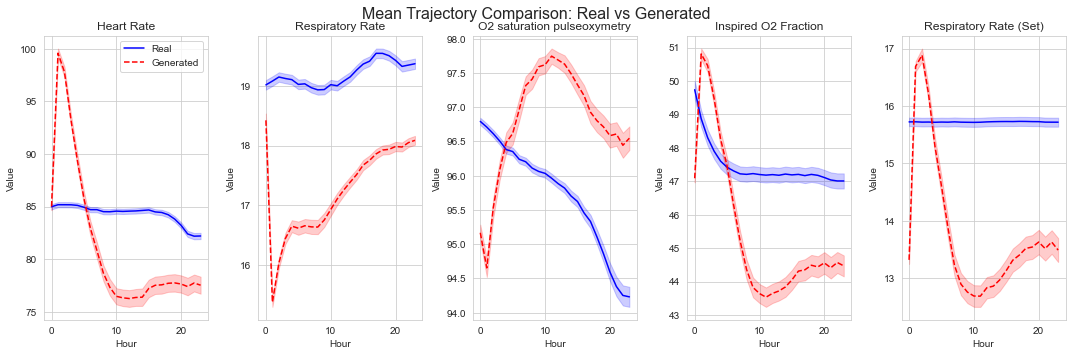

In [12]:
# Plot real and generated mean trajectories together
def plot_mean_trajectory_comparison(real_data, gen_data):
    real_mean = np.mean(real_data, axis=0)
    gen_mean = np.mean(gen_data, axis=0)
    
    plt.figure(figsize=(15, 5))
    for i, feature_name in enumerate(continuous_feature_names):
        plt.subplot(1, real_data.shape[2], i+1)
        plt.plot(range(real_data.shape[1]), real_mean[:, i], 'b-', label='Real')
        plt.plot(range(gen_data.shape[1]), gen_mean[:, i], 'r--', label='Generated')
        plt.title(f'{feature_name}')
        plt.xlabel('Hour')
        plt.ylabel('Value')
        
        # Add confidence intervals for more comprehensive comparison
        real_std = np.std(real_data[:, :, i], axis=0)
        gen_std = np.std(gen_data[:, :, i], axis=0)
        
        # 95% confidence bands (mean ± 1.96*std/√n)
        real_ci = 1.96 * real_std / np.sqrt(len(real_data))
        gen_ci = 1.96 * gen_std / np.sqrt(len(gen_data))
        
        x = range(real_data.shape[1])
        plt.fill_between(x, real_mean[:, i] - real_ci, real_mean[:, i] + real_ci, 
                         color='blue', alpha=0.2)
        plt.fill_between(x, gen_mean[:, i] - gen_ci, gen_mean[:, i] + gen_ci, 
                         color='red', alpha=0.2)
        
        # Only add legend to first subplot to avoid redundancy
        if i == 0:
            plt.legend()
            
    plt.tight_layout()
    plt.suptitle('Mean Trajectory Comparison: Real vs Generated', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the function with your data
plot_mean_trajectory_comparison(continuous_x_renorm, c_gen_data_renorm)

### 9. Quantitative Evaluation

Training discriminator for continuous data...
Train on 13668 samples, validate on 3418 samples
Epoch 1/10
13668/13668 [==============================] - 6s 452us/sample - loss: 0.2264 - acc: 0.9268 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 2/10
13668/13668 [==============================] - 1s 39us/sample - loss: 0.0145 - acc: 0.9998 - val_loss: 6.7278e-04 - val_acc: 1.0000
Epoch 3/10
13668/13668 [==============================] - 1s 39us/sample - loss: 0.0023 - acc: 0.9999 - val_loss: 2.8958e-04 - val_acc: 1.0000
Epoch 4/10
13668/13668 [==============================] - 1s 39us/sample - loss: 6.4585e-04 - acc: 0.9999 - val_loss: 7.9096e-05 - val_acc: 1.0000
Epoch 5/10
13668/13668 [==============================] - 1s 39us/sample - loss: 0.0057 - acc: 0.9996 - val_loss: 3.2536e-04 - val_acc: 1.0000
Epoch 6/10
13668/13668 [==============================] - 1s 39us/sample - loss: 7.7315e-04 - acc: 0.9999 - val_loss: 7.9400e-05 - val_acc: 1.0000
Epoch 7/10
13668/13668 [==================

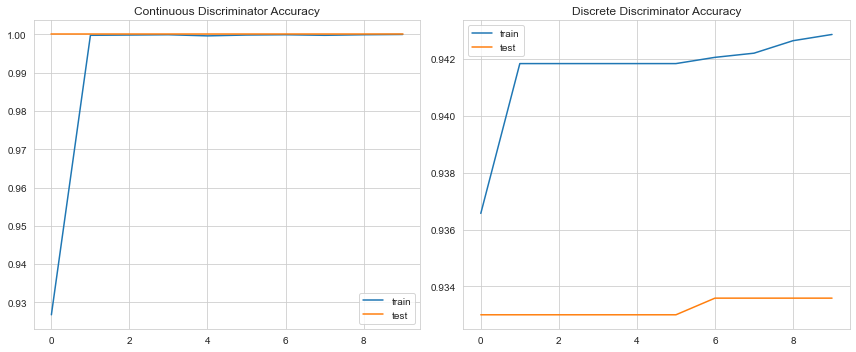

In [13]:
# Train a model to distinguish real from generated data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

def train_discriminator(real, gen):
    # Prepare data
    real_flat = real.reshape(real.shape[0], -1)
    gen_flat = gen.reshape(gen.shape[0], -1)
    
    # Combine and create labels
    X = np.vstack([real_flat, gen_flat])
    y = np.concatenate([np.zeros(len(real_flat)), np.ones(len(gen_flat))])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    # Create a simple discriminator model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])  # Use 'acc' for TF1.x
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,
        batch_size=128
    )
    
    # Evaluate model
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    apr = average_precision_score(y_test, y_pred)
    
    return auc, apr, history

# Evaluate discriminative performance
print("Training discriminator for continuous data...")
c_auc, c_apr, c_history = train_discriminator(continuous_x, c_gen_data_renorm)
print(f"Continuous data - AUC: {c_auc:.4f}, APR: {c_apr:.4f}")

print("\nTraining discriminator for discrete data...")
d_auc, d_apr, d_history = train_discriminator(discrete_x, d_gen_data)
print(f"Discrete data - AUC: {d_auc:.4f}, APR: {d_apr:.4f}")

# In an ideal GAN, AUC should be close to 0.5 (indistinguishable)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(c_history.history['acc'], label='train')
plt.plot(c_history.history['val_acc'], label='test')
plt.title('Continuous Discriminator Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_history.history['acc'], label='train')
plt.plot(d_history.history['val_acc'], label='test')
plt.title('Discrete Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 10. Summary and Recommendations

In [14]:
# Display final summary
print("M3GAN Model Training Summary")
print("-" * 40)
print(f"Dataset: MIMIC-IV with {patinet_num} patients")
print(f"Features: {c_dim} continuous, {d_dim} discrete")
print(f"Time steps: {time_steps} hours")
print(f"Pre-training epochs: {num_pre_epochs}")
print(f"Training epochs: {num_epochs}")
print("\nGenerated data quality:")
print(f"Continuous data AUC: {c_auc:.4f} (closer to 0.5 is better)")
print(f"Discrete data AUC: {d_auc:.4f} (closer to 0.5 is better)")
print(f"Mean correlation difference: {np.mean(corr_diff):.4f} (lower is better)")
print("\nTraining files:")
print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Generated data: data/fake/gen_data_mimiciv_{filename_postfix}_corrected.npz")

# Recommendations
print("\nRecommendations:")
print("1. For low variance in first hour: Applied variance matching as a post-processing step")
print("2. For better stability: Consider using gradient penalty or spectral normalization")
print("3. For better feature correlations: Increase the alpha_mt parameter")
print("4. For more realistic trajectories: Increase the number of GAN training epochs")
print("5. For more diverse samples: Consider reducing batch size or adding noise during generation")

M3GAN Model Training Summary
----------------------------------------
Dataset: MIMIC-IV with 16062 patients
Features: 5 continuous, 1 discrete
Time steps: 24 hours
Pre-training epochs: 300
Training epochs: 500

Generated data quality:
Continuous data AUC: 1.0000 (closer to 0.5 is better)
Discrete data AUC: 0.7193 (closer to 0.5 is better)
Mean correlation difference: 0.4136 (lower is better)

Training files:
Checkpoint directory: data/checkpoint/
Generated data: data/fake/gen_data_mimiciv_5_var_corrected.npz

Recommendations:
1. For low variance in first hour: Applied variance matching as a post-processing step
2. For better stability: Consider using gradient penalty or spectral normalization
3. For better feature correlations: Increase the alpha_mt parameter
4. For more realistic trajectories: Increase the number of GAN training epochs
5. For more diverse samples: Consider reducing batch size or adding noise during generation


### 11. Close Session

In [15]:
# Close the TensorFlow session
# TODO: Uncomment to close the session!!!
# sess.close()
# print("TensorFlow session closed")